In [1]:
import requests
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
import osmnx as ox
from haversine import haversine, haversine_vector

In [2]:
from utils.utils import *
from utils import gpx_converter
from utils.interpolate import batch_geo_interpolate_df

In [4]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.12; rv:55.0) Gecko/20100101 Firefox/55.0',}

# Row data

## Download Cambridgeshire ROW data

In [18]:
row_response = requests.get("https://www.rowmaps.com/getgpx.php", params={"l": "CB", "w": "no"}, headers=headers)

In [19]:
with open("data/row/row.gpx", "wb") as f:
    f.write(row_response.content)

## Convert ROW to csv

In [5]:
gpx_converter.Converter(input_file='data/row/row.gpx').gpx_to_csv(output_file='data/row/row_raw.csv')

True

## Interpolate and save

In [3]:
row_raw_df = pd.read_csv("data/row/row_raw.csv")

In [4]:
row_df = batch_geo_interpolate_df(row_raw_df, dist_m=INTERPOLATION_DIST_ROW_GPS, segmentation=False)

  0%|          | 0/4601 [00:00<?, ?it/s]

In [5]:
row_df.to_csv("data/row/row.csv", index=False)

## Get arbitrary bbox to work with, within ROW boundaries

In [27]:
from scipy import spatial

In [23]:
row_df = pd.read_csv("data/row/row_raw.csv")
row_arr = row_df[["longitude", "latitude"]].to_numpy()
print(row_arr.shape)

(98169, 2)


In [28]:
hull_points = row_arr[spatial.ConvexHull(row_arr, qhull_options="Qt").vertices, :]
bbox = [*(row_arr.min(axis=0)), *(row_arr.max(axis=0))]
hw = 0.05
bbox = [(bbox[2]+bbox[0])/2-hw, (bbox[3]+bbox[1])/2-hw, (bbox[2]+bbox[0])/2+hw, (bbox[3]+bbox[1])/2+hw]

In [29]:
print(bbox)
np.savetxt("data/bbox.csv", bbox, delimiter=",")

[-0.04285499999999999, 52.32761000000001, 0.057145000000000015, 52.42761]


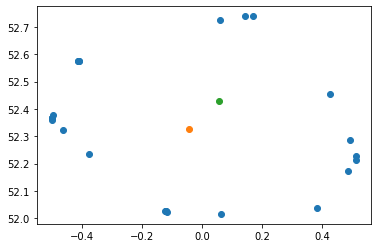

In [30]:
import matplotlib.pyplot as plt
l,b,r,t = bbox
plt.scatter(hull_points[:,0], hull_points[:,1])
plt.scatter(l,b)
plt.scatter(r,t)

## Get ROW within bbox

In [6]:
row_df = pd.read_csv("data/row/row.csv")
bbox = np.loadtxt("data/bbox.csv", delimiter=",", dtype=np.float32)

In [7]:
box_row_df = row_df.loc[in_box(row_df["latitude"], row_df["longitude"], bbox=bbox)]

In [8]:
box_row_df.to_csv("data/row/row_bbox.csv", index=False)

# Public GPS data

## Download subset of East Anglia GPS data

In [62]:
!curl -o data/public/public_east_of_england.tar.xz http://zverik.openstreetmap.ru/gps/files/extracts/europe/great_britain/east-of-england.tar.xz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  173M    0  267k    0     0   461k      0  0:06:26 --:--:--  0:06:26  462k
  1  173M    1 3070k    0     0  1899k      0  0:01:33  0:00:01  0:01:32 1902k
  5  173M    5 10.2M    0     0  4049k      0  0:00:43  0:00:02  0:00:41 4052k
  9  173M    9 16.2M    0     0  4654k      0  0:00:38  0:00:03  0:00:35 4656k
 13  173M   13 23.6M    0     0  5280k      0  0:00:33  0:00:04  0:00:29 5282k
 15  173M   15 27.4M    0     0  5033k      0  0:00:35  0:00:05  0:00:30 5565k
 18  173M   18 32.0M    0     0  4993k      0  0:00:35  0:00:06  0:00:29 5999k
 19  173M   19 34.4M    0     0  4660k      0  0:00:38  0:00:07  0:00:31 4977k
 21  173M   21 37.4M    0     0  4470k      0  0:00:39  0:00:08  0:00:31 4340k
 23  173M   23 40.7M    0     0  4361k      0  0:00

In [63]:
!tar -xvf data/public/public_east_of_england.tar.xz -C data/public

gpx-planet-2013-04-09/metadata.xml
gpx-planet-2013-04-09/identifiable/001/005/001005365.gpx
gpx-planet-2013-04-09/identifiable/001/005/001005323.gpx
gpx-planet-2013-04-09/identifiable/001/005/001005355.gpx
gpx-planet-2013-04-09/identifiable/001/005/001005312.gpx
gpx-planet-2013-04-09/identifiable/001/005/001005311.gpx
gpx-planet-2013-04-09/identifiable/001/005/001005219.gpx
gpx-planet-2013-04-09/identifiable/001/005/001005335.gpx
gpx-planet-2013-04-09/identifiable/001/005/001005405.gpx
gpx-planet-2013-04-09/identifiable/001/005/001005261.gpx
gpx-planet-2013-04-09/identifiable/001/005/001005974.gpx
gpx-planet-2013-04-09/identifiable/001/005/001005645.gpx
gpx-planet-2013-04-09/identifiable/001/005/001005643.gpx
gpx-planet-2013-04-09/identifiable/001/273/001273910.gpx
gpx-planet-2013-04-09/identifiable/001/273/001273447.gpx
gpx-planet-2013-04-09/identifiable/001/273/001273911.gpx
gpx-planet-2013-04-09/identifiable/001/273/001273557.gpx
gpx-planet-2013-04-09/identifiable/001/273/001273567.

In [66]:
!rm data/public/public_east_of_england.tar.xz

In [7]:
from pathlib import Path

In [8]:
all_gps_paths = list(Path("data/public/gpx-planet-2013-04-09").rglob("*.gpx"))

In [9]:
len(all_gps_paths)

8829

In [12]:
frames = []
for idx,gps_path in tqdm(enumerate(all_gps_paths)):
    df = gpx_converter.Converter(input_file=gps_path).gpx_to_dataframe(i=idx)
    df = df[["latitude", "longitude", "trackid"]]
    df = df.loc[(df[["latitude", "longitude"]] != 0).all(axis=1), :]
    frames.append(df)
all_gps_raw_df = pd.concat(frames, ignore_index=True)

8829it [1:09:12,  2.13it/s]


In [15]:
all_gps_raw_df.to_csv("data/public/public_gps_traces_raw.csv", index=False)

## Get GPS traces within bbox

In [3]:
bbox = np.loadtxt("data/bbox.csv", delimiter=",", dtype=np.float32)

In [4]:
all_gps_raw_df = pd.read_csv("data/public/public_gps_traces_raw.csv")

In [5]:
box_gps_df = all_gps_raw_df.loc[in_box(all_gps_raw_df["latitude"], all_gps_raw_df["longitude"], bbox=bbox)]

In [6]:
box_gps_df.to_csv("data/public/public_gps_traces_raw_bbox.csv", index=False)

## Interpolate GPS traces

In [4]:
all_gps_raw_df = pd.read_csv("data/public/public_gps_traces_raw_bbox.csv")

In [7]:
G = ox.load_graphml("data/osmnx/graph.graphml")

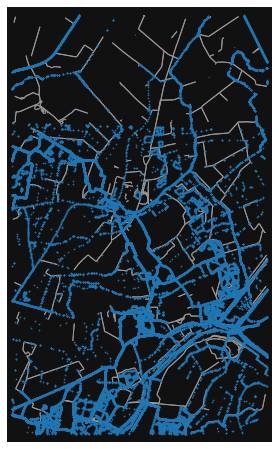

In [9]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.scatter(all_gps_raw_df["longitude"], all_gps_raw_df["latitude"], s=2, marker='.')

In [5]:
all_gps_df = batch_geo_interpolate_df(all_gps_raw_df, dist_m=INTERPOLATION_DIST_PUBLIC_GPS)

  0%|          | 0/64 [00:00<?, ?it/s]

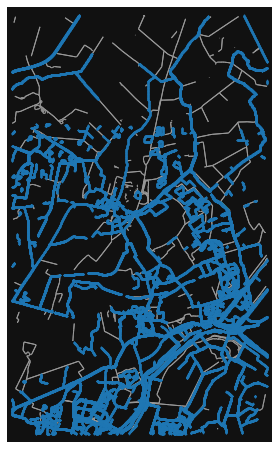

In [8]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.scatter(all_gps_df["longitude"], all_gps_df["latitude"], s=2, marker='.')

In [9]:
all_gps_df.to_csv("data/public/public_gps_traces_bbox.csv", index=False)

# OSM road data 

## Download OSM data from bbox and save graph

In [3]:
import osmnx as ox

In [4]:
bbox = np.loadtxt("data/bbox.csv", delimiter=",", dtype=np.float32)

In [5]:
%%time
G = ox.graph_from_bbox(bbox[3], bbox[1], bbox[2], bbox[0], 
                       custom_filter='["highway"~"footway|cycleway|bridleway|path|track"]', 
                       retain_all=True, simplify=False).to_undirected()

Wall time: 2.44 s


In [6]:
G.is_directed()

False

In [7]:
ox.save_graphml(G, "data/osmnx/graph.graphml")

In [9]:
print(bbox)

[-0.042855 52.32761   0.057145 52.42761 ]


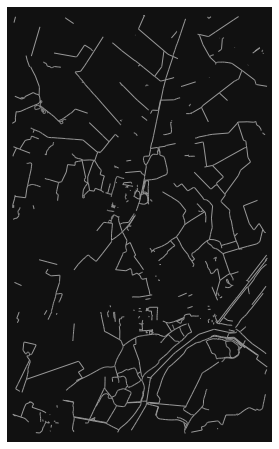

In [8]:
fig, ax = ox.plot_graph(G, node_size=0)

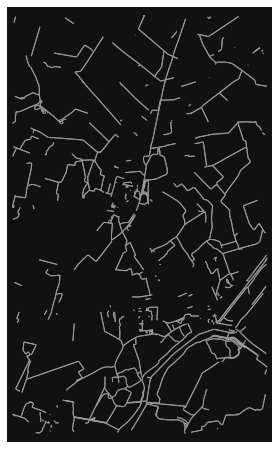

In [10]:
fig, ax = ox.plot_graph(G, node_size=0)